# Customer Churn Prediction

Customer churn is a critical challenge for subscription-based businesses, particularly in the telecommunications industry. Churn occurs when customers discontinue their services, resulting in revenue loss and increased acquisition costs to replace them. Studies show that retaining existing customers is often more cost-effective than acquiring new ones, making churn prediction an essential task for business growth.
The goal of this project is to predict customer churn using machine learning. By analysing customer demographic data, account details, and usage patterns, we can build a predictive model that classifies customers into two groups:
* Churn (1) → Customers likely to discontinue services.
* No Churn (0) → Customers expected to remain with the company.

This predictive capability enables businesses to design targeted retention strategies, such as personalised offers, loyalty programs, or improved customer service interventions, ultimately reducing churn rates and boosting customer satisfaction.
In this notebook, we will:
1. Explore and preprocess the Telco Customer Churn dataset.
2. Perform exploratory data analysis (EDA) to uncover trends and correlations.
3. Train and evaluate machine learning models for churn prediction.

In [1]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
)

I used the Telco Customer Churn dataset, which contains demographic information, account details, and service usage patterns of customers from a telecommunications company. Each record is labeled with a target variable:
* Churn → whether the customer left the company (Yes/No).

The dataset will first be loaded into a pandas DataFrame for exploration and preprocessing.

In [2]:
# --- Load Data ---
df = pd.read_csv("/Users/godenaan/godenaan-ds-portfolio/assets/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("Shape:", df.shape)
df.head()

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Cleaning

In [3]:
# Checking datatypes and missing values
print(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())

# Converting TotalCharges to numeric (it sometimes loads as object)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Filling missing values in TotalCharges with median
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# Droping customerID (not useful for training a model)
df.drop("customerID", axis=1, inplace=True)

# Verifing cleaning
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Exploratory Data Analysis (EDA)

In this section, I analyze the dataset to understand its structure, detect patterns, and uncover relationships between variables that may influence customer churn.
1. Dataset Overview
    * We begin by examining the shape, column names, and data types.
    * We check for missing values, duplicates, and inconsistencies in the dataset.

2. Target Variable Distribution
    * The proportion of customers who churned (Churn = Yes) versus those who did not (Churn = No) is visualized.
    * This step helps identify whether the dataset is imbalanced, which may influence model training.

3. Numerical Features Analysis
    * Features such as tenure, MonthlyCharges, and TotalCharges are analyzed with descriptive statistics and histograms.
    * This helps us understand customer behavior patterns, e.g., customers with shorter tenure or higher monthly charges may be more likely to churn.

4. Categorical Features Analysis
    * Key categorical variables like Contract, PaymentMethod, InternetService, and Gender are explored with count plots and churn breakdowns.
    * These insights reveal service-related factors that might drive customer churn.
    
5. Correlation Analysis
    * Correlation matrices and heatmaps are used to identify relationships among numerical variables.
    * This allows us to detect multicollinearity and spot variables strongly associated with churn.

Through this analysis, we gain critical insights into the drivers of churn, guiding both feature engineering and model selection in later stages.

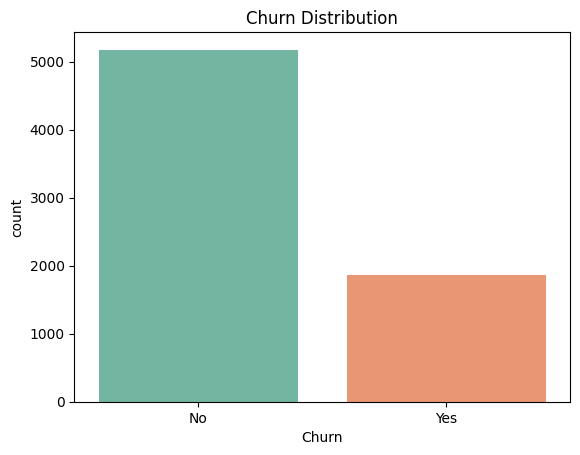

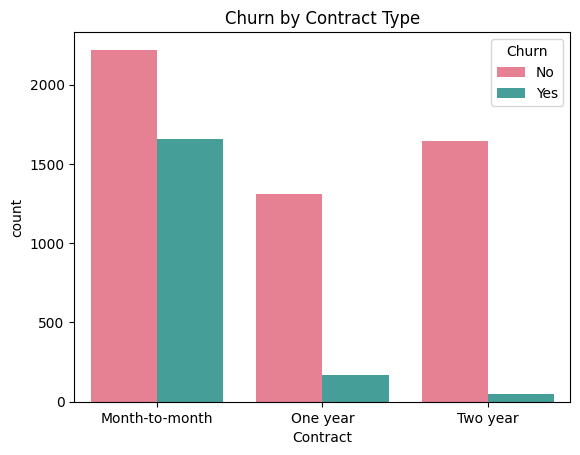

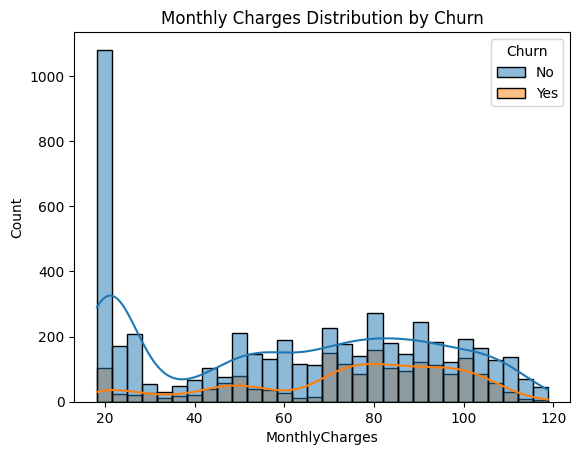

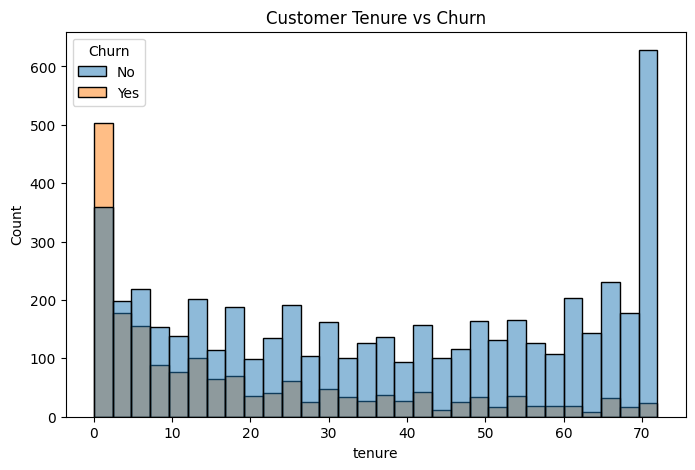

In [4]:
# 1. Churn distribution
sns.countplot(x="Churn", hue="Churn", data=df, palette="Set2", legend=False)
plt.title("Churn Distribution")
plt.show()

# 2. Contract type vs Churn
sns.countplot(x="Contract", hue="Churn", data=df, palette="husl")
plt.title("Churn by Contract Type")
plt.show()

# 3. Monthly charges distribution by churn
sns.histplot(data=df, x="MonthlyCharges", hue="Churn", bins=30, kde=True)
plt.title("Monthly Charges Distribution by Churn")
plt.show()

# 4. Tenure vs Churn
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="tenure", hue="Churn", bins=30, kde=False)
plt.title("Customer Tenure vs Churn")
plt.show()


# Using a tight layout

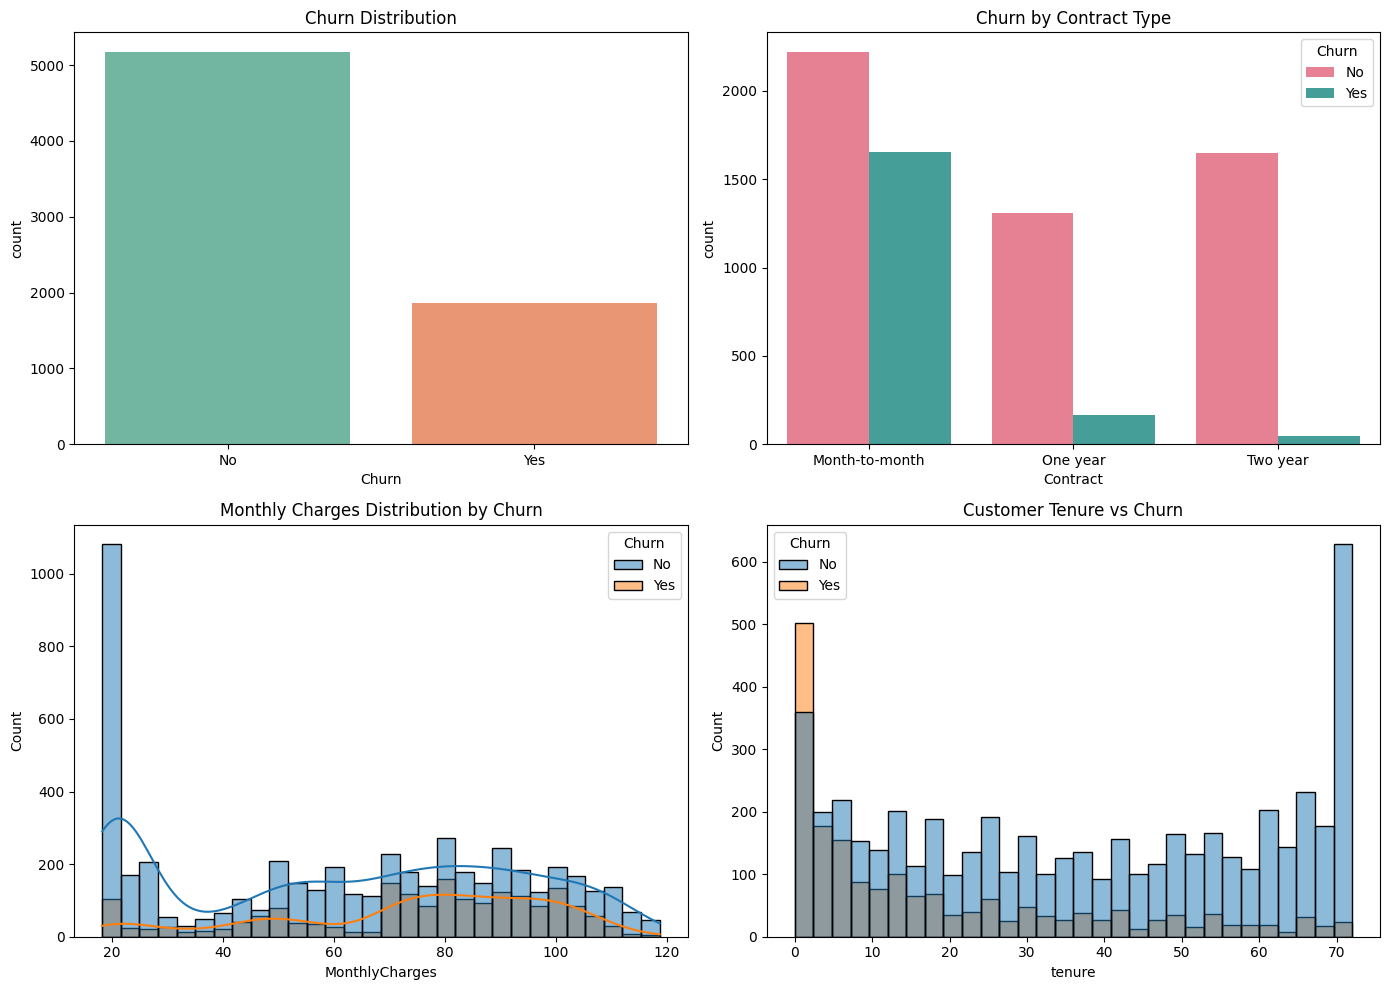

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Churn distribution
sns.countplot(ax=axes[0,0], x="Churn", hue="Churn", data=df, palette="Set2", legend=False)
axes[0,0].set_title("Churn Distribution")

# 2. Contract type vs Churn
sns.countplot(ax=axes[0,1], x="Contract", hue="Churn", data=df, palette="husl")
axes[0,1].set_title("Churn by Contract Type")

# 3. Monthly charges distribution by churn
sns.histplot(ax=axes[1,0], data=df, x="MonthlyCharges", hue="Churn", bins=30, kde=True)
axes[1,0].set_title("Monthly Charges Distribution by Churn")

# 4. Tenure vs Churn
sns.histplot(ax=axes[1,1], data=df, x="tenure", hue="Churn", bins=30, kde=False)
axes[1,1].set_title("Customer Tenure vs Churn")

plt.tight_layout()
plt.show()


## Preprocessing

In [6]:
# Encoding categorical variables (convert Yes/No, Male/Female, etc. into numbers)
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Features (X) and target (y)
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling numerical features for better performance.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (5634, 19)
Test set shape: (1409, 19)


## Modeling 

The goal of this stage is to build a predictive model that classifies customers into two categories: Churn (1) and No Churn (0).


Logistic Regression

Why Logistic Regression?
We selected Logistic Regression as our primary model for the following reasons:
1. Simplicity & Interpretability
2. Handles Imbalanced Data with Class Weights
3. Baseline Performance
4. Probability Predictions


Modeling Steps
1. Model Initialization
    * We initialize a Logistic Regression model with class balancing enabled to account for the skewed churn distribution.
2. Model Training
    * The model is trained on the preprocessed dataset, learning the relationship between customer features and churn outcome.



In [7]:
log_model_balanced = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight="balanced"
)

log_model_balanced.fit(X_train, y_train)

# Predictions
y_pred_log_bal = log_model_balanced.predict(X_test)

# Evaluation
print("Balanced Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_bal))
print("Balanced Logistic Regression F1 Score:", f1_score(y_test, y_pred_log_bal))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log_bal))


Balanced Logistic Regression Accuracy: 0.7395315826827538
Balanced Logistic Regression F1 Score: 0.6188992731048806

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



3. Evaluation
    * The model is evaluated using Accuracy, Precision, Recall, and F1-Score.
    * A Confusion Matrix is also generated to visualize prediction performance across both classes.

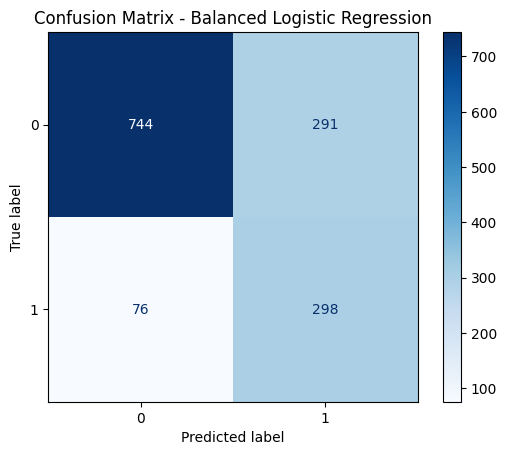

In [8]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_log_bal)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model_balanced.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Balanced Logistic Regression")
plt.show()

## Testing the Model

4. Predictions
    * The trained model predicts churn on the test set.
    * Both class labels (0 = No Churn, 1 = Churn) and probabilities are generated.

In [9]:
# Create a dummy sample with 19 features
new_sample = np.array([[
    0, 1, 0, 1, 0, 12, 1, 0, 1, 0, 
    1, 0, 0, 1, 1, 0, 1, 50.5, 2000
]])

# Predict
prediction = log_model_balanced.predict(new_sample)
probability = log_model_balanced.predict_proba(new_sample)

print(f"Predicted Class: {prediction[0]} "
      f"({'Churn' if prediction[0]==1 else 'No Churn'}) "
      f"with probability {probability.max():.2f}")


Predicted Class: 1 (Churn) with probability 1.00


# Saving the model

In [10]:
# Save model
joblib.dump(log_model_balanced, "churn_model.pkl")

# Load model
loaded_model = joblib.load("churn_model.pkl")
